<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Structured_Bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import autokeras as ak
import tensorflow as tf

#### Load Data

In [13]:
# Load data, encoding with GBK
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', encoding='gbk')

# # Revise column names 有些欄位有亂碼,須修正其欄位名稱
df = df.rename(columns={'Temperature(癈)': 'Temperature(*C)', 'Dew point temperature(癈)': 'Dew point(*C)'})
df

,Date,Rented Bike Count,Hour,Temperature(*C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point(*C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [14]:
# Function day = NO, 租借人數必為0, 故從資料集略過這些資料
df = df[df['Functioning Day'] == 'Yes']

# 移除目標與多餘的資訊欄
x = df.drop(['Rented Bike Count', 'Date', 'Functioning Day'], axis=1)

# 目標值單位變成千人,數值減小有助於更快收斂
y = df['Rented Bike Count'] / 1000

y.describe()

count    8465.000000
mean        0.729157
std         0.642351
min         0.002000
25%         0.214000
50%         0.542000
75%         1.084000
max         3.556000
Name: Rented Bike Count, dtype: float64

In [15]:
# 注意其資料集x_train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Model
示範將原來的StructuredDataBlock細分成更小的區塊


In [16]:
# input
input_node = ak.StructuredDataInput()

output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.Normalization()(output_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.RegressionHead()(output_node)

callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_mae')]

reg = ak.AutoModel(inputs=input_node, outputs=output_node,
          # model以最小化val_mae為目標,並顯示mae指標
          objective='val_mae', metrics=['mae'],
          max_trials=3, overwrite=True)
reg.fit(x_train, y_train, callbacks=callbacks)

Trial 3 Complete [00h 01m 58s]
val_mae: 0.23583345115184784

Best val_mae So Far: 0.2190367728471756
Total elapsed time: 00h 06m 21s
INFO:tensorflow:Oracle triggered exit
212/212 [==============================] - 2s 5ms/step - loss: 0.3269 - mae: 0.4124
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


#### Evaluate

In [17]:
reg.evaluate(x_test, y_test)

53/53 [==============================] - 0s 5ms/step - loss: 0.2197 - mae: 0.3431


[0.21967267990112305, 0.34312301874160767]

In [18]:
predicted = reg.predict(x_test).flatten() * 1000
real = y_test.to_numpy() * 1000

for i in range(10):
    print('Predicted:', predicted[i].round(3))
    print('Real:', real[i].round(0))
    print('')

53/53 [==============================] - 0s 3ms/step
Predicted: 1381.478
Real: 1232.0

Predicted: 1089.866
Real: 964.0

Predicted: 856.91
Real: 942.0

Predicted: 359.572
Real: 373.0

Predicted: 1185.976
Real: 1259.0

Predicted: 1126.044
Real: 476.0

Predicted: 1109.286
Real: 1062.0

Predicted: 217.624
Real: 253.0

Predicted: 1232.836
Real: 2857.0

Predicted: 632.842
Real: 1039.0



In [19]:
from sklearn.metrics import r2_score
r2_score(real, predicted).round(3)

0.44

#### Predict

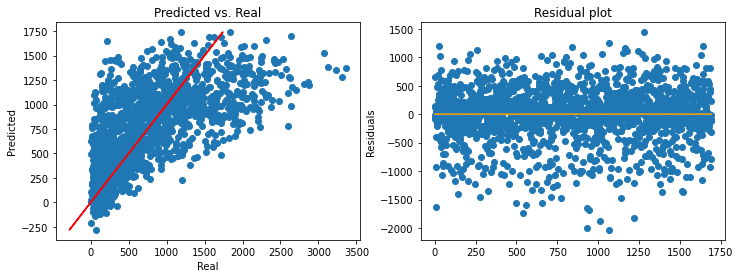

In [20]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
plt.scatter(real, predicted)
plt.plot(predicted, predicted, color='red')
ax.set_title('Predicted vs. Real')
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')

ax = fig.add_subplot(1, 2, 2)
plot_x = np.arange(predicted.size)
plt.scatter(plot_x, (predicted - real))
plt.plot(plot_x, plot_x * 0, color='orange')
ax.set_title('Residual plot')
ax.set_ylabel('Residuals')

plt.show()

#### Export Model

In [21]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 11)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 11)               23        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                384       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

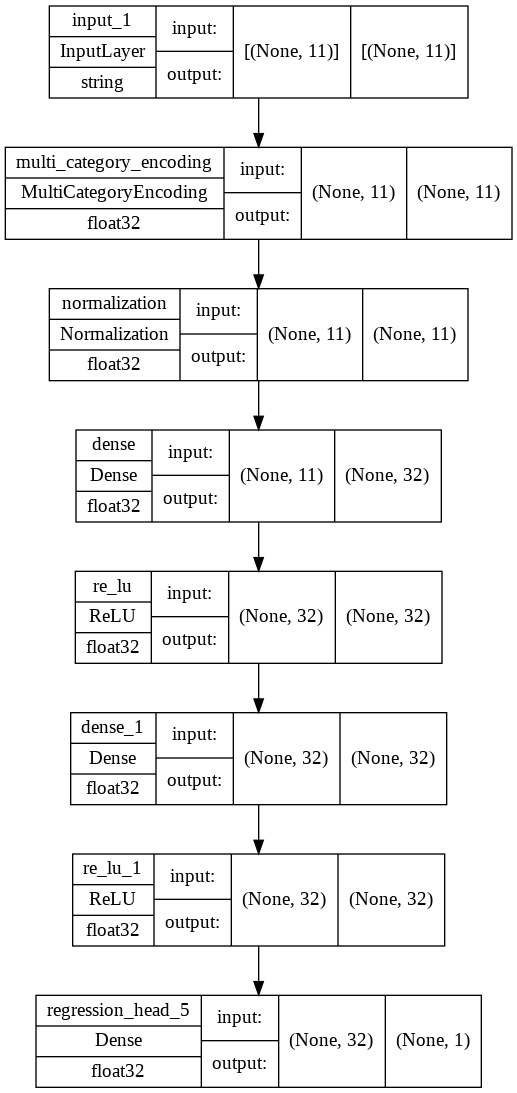

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True)

#### Load model

In [23]:
from tensorflow.keras.models import load_model
loaded_model = load_model('./auto_model/best_model', custom_objects=ak.CUSTOM_OBJECTS)

In [24]:
loaded_model.evaluate(x_test.astype('str'), y_test)

53/53 [==============================] - 0s 4ms/step - loss: 0.2197 - mae: 0.3431


[0.21967267990112305, 0.34312301874160767]

In [25]:
predicted = loaded_model.predict(x_test.astype('str')).flatten() * 1000

from sklearn.metrics import r2_score
r2_score(real, predicted).round(3)

0.44